SC3000 A36, Lab Project 1 
<p>Team Members:
Rungta Dhairya, 
Oza Tirth Tusharbhai<p>
<p>Equal Contribution and sharing of workload. <p>
<p>Rungta Dhairya: Researching the agent and the development of the models and inital testing and tuning<p>
<p>Oza Tirth Tusharbhai: Training of model, testing and running model, formatting of jupyter notebook.<p> 

<p> Running of notebook: we have tested running the final notebook on google colab. Running the model and rendering it on local machine requires changes sometimes depending the dependencies. The changes affect code for reshaping the input dimensions and the observation dimensions from the action.

One weird observation we made also was when we run the model using the pre-trained weights in the "answer_weights.h5" file on our local machines the consistent result is a score of 500. We have tried it with multiple machines and we get the same result. But running the same agent with same weights on google colab gives a consistent score of 200 for all episodes. We tried figuring out why this could be but to no conclusion. Both of us thought it was a fun observation and we should mention it.
 <p>

<p>The full outputs for the training and testing codes are present as cell ouputs. The output cell might be collapsed when loaded though because of the size of the outputs.<p>


### Importing Dependencies:



In [ ]:
import random
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam


### The following code cell has the following Functions:
* An initialization function to initialize all the variables.
* A function to build the neural network model using Keras.
* A function to remember the current experience. We need a memory of previous experiences and observations to re-train the model with the earlier experiences. It stores the experience in this format in the memory: 
##### [state, action, reward, next_state, done]. 
##### 'done' is a boolean that indicates if the state is the final state.
* A batch update method is also implemented here. This batch update method is more stable compared to incremental update as it trains the model on a fixed set of samples in each iteration.
* 'load' and 'save' functions to load and save the weights of the trained neural network.


Explanation of the actual DQN agent 

* 3 layer seqeuntial neural network model.
* one input layer and one output layer.
* input layer accepts a tensor of size (1,4)
* the correct input for the network is achievend by reshaping the observation vector which is of size (4) into a tensor of size (1,4) using numpy operations
* the output layer gives a tensor of size (1,2), which has the expected return for performing action 0, 1 in the given state. The action returned is the action with the higher Q value, hence we use the np.argmax() funciton. 
* we use batch update for trainig the model, the entries for batch updates are stored in a memory implemented using deque. Batch size we chose here is 64. This means that from the memory we select random 64 samples and use them for updating the weights of the model using back propogation. This allows for the same episode being used for multiple batch updates. In formal terms this is also called experience replay. There is a way of implementing prioritised experience replay but we have not implmeneted here since the model is giving quite good results with the normal experience replay. 
* we use batch updates instead of incremental updates because batch updates are a lot more stable and doesn't allow the agent to be serverly affected by one single episode 
* the last important part of the model is the epsilon value which is the exploration rate and the discount rate. The value of epsilon keeps reducing after every batch update and for training reaches the minimum value of 0.01.




In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.99         # discount rate
        self.epsilon = 1.0        # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        self.learning_rate = 0.001
        self.train_start = 1000
        self.model = self._build_model()

  
    def _build_model(self):
      # Neural Network for Deep-Q learning model
      model = Sequential()
      model.add(Dense(24, input_dim=self.state_size, activation='relu'))
      model.add(Dense(24, activation='relu'))
      model.add(Dense(self.action_size, activation='linear'))
      model.summary()
      model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
      return model

    def remember(self, state, action, reward, next_state, done):
      self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
      if np.random.random() <= self.epsilon:
          return random.randrange(self.action_size)
      else:
          q_values = self.model.predict(state)
          return np.argmax(q_values[0])   # returns action
  
  # Batch update - it is more stable compared to incremental update
    def replay2(self, batch_size):

      minibatch = random.sample(self.memory, batch_size)

      current_state = np.zeros((batch_size, self.state_size))
      next_state = np.zeros((batch_size, self.state_size))
      action, reward, done = [], [], []

      for i in range(batch_size):
        current_state[i] = minibatch[i][0]  
        action.append(minibatch[i][1])
        reward.append(minibatch[i][2])
        next_state[i] = minibatch[i][3]  
        done.append(minibatch[i][4])

      targetQvalue = self.model.predict(current_state) # for current state
      Qvalue_ns = self.model.predict(next_state)    # for next state

      for i in range(batch_size):
        if done[i]:
            targetQvalue[i][action[i]] = reward[i]
        else:
            targetQvalue[i][action[i]] = reward[i] + self.gamma * (
                np.amax(Qvalue_ns[i]))

    # train the model
      self.model.fit(current_state, targetQvalue, batch_size=batch_size,
                   epochs=1, verbose=0)
      if (self.epsilon > self.epsilon_min) and \
       (len(self.memory) >= self.train_start):
        self.epsilon *= self.epsilon_decay
    
    
    def load(self, name):
      self.model.load_weights(name)

    def save(self, name):
      self.model.save_weights(name)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Training Code
* This code initializes an OpenAI Gym environment for the "CartPole-v0" task. 
* The code then creates an instance of the DQNAgent class, which implements a deep Q-network (DQN) algorithm for solving the task. 
* The agent uses an epsilon-greedy policy to explore the environment and improve its policy over time.
* The agent's act method selects an action to take based on the current epsilon value, which is initialized to 1.0 and decays over time.
* The agent is trained for 300 episodes here.
* The code also periodically saves the agent's learned weights to a file (agent.save("./train_weights.h5")) every 10 episodes to allow for resuming training or loading the trained agent later.

In [ ]:
# initialize the environment
env = gym.make('CartPole-v0')
print(env.observation_space.shape)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n 
agent = DQNAgent(state_size, action_size)
EPISODES = 300
done = False 
batch_size = 64
score1 = []
avg100Scores=[]
episode1 = []
for e in range(EPISODES):
    
    if e%10 ==0 :
        agent.save("./train_weights.h5")  
        # dill.dump_session('main_notebook.db')
        
    state = env.reset()
    # state = (state[0])
    state = np.reshape(state, [1,state_size])

    done = False
    t = 0
    while not done:
        # env.render()
        
        
        action = agent.act(state)
        # next_state, reward, done,info, _ = env.step(action)
        next_state, reward, done,info = env.step(action)

        reward = reward if not done else -100   
        next_state = np.reshape(next_state, [1,state_size])

      # remember
        agent.remember(state, action, reward, next_state, done)
        state = next_state

        t += 1

      # experience replay
        if len(agent.memory) > batch_size:
          agent.replay2(batch_size) 

        if t>=500:
            break

    print("episode: {}, score: {}, e: {:.2}, memory length: {}"\
          .format(e, t, agent.epsilon, len(agent.memory) ))
    score1.append(t)
    episode1.append(e)
    
    if  len(score1)>=100:
        avg100Scores.append(np.mean(score1[-min(100, len(score1)):]))
          


(4,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                120       
                                                                 
 dense_1 (Dense)             (None, 24)                600       
                                                                 
 dense_2 (Dense)             (None, 2)                 50        
                                                                 
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________
episode: 0, score: 60, e: 1.0, memory length: 60
2/2 [==============================] - 0s 0s/step


C:\Users\AlanWang\anaconda3\envs\gym\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
C:\Users\AlanWang\anaconda3\envs\gym\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\AlanWang\anaconda3\envs\gym\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


2/2 [==============================] - 0s 999us/step
episode: 1, score: 11, e: 1.0, memory length: 71
2/2 [==============================] - 0s 998us/step
episode: 2, score: 8, e: 1.0, memory length: 79
2/2 [==============================] - 0s 0s/step
episode: 3, score: 11, e: 1.0, memory length: 90
2/2 [==============================] - 0s 0s/step
episode: 4, score: 17, e: 1.0, memory length: 107
2/2 [==============================] - 0s 999us/step
episode: 5, score: 26, e: 1.0, memory length: 133
2/2 [==============================] - 0s 11ms/step
episode: 6, score: 18, e: 1.0, memory length: 151
2/2 [==============================] - 0s 1000us/step
episode: 7, score: 42, e: 1.0, memory length: 193
2/2 [==============================] - 0s 2ms/step
episode: 8, score: 30, e: 1.0, memory length: 223
2/2 [==============================] - 0s 2ms/step
episode: 9, score: 25, e: 1.0, memory length: 248
2/2 [==============================] - 0s 2ms/step
episode: 10, score: 21, e: 1.0, memo

### Printing the average 100 scores for training for 300 episdoes.

In [ ]:
print(avg100Scores)

[92.73, 93.53, 94.57, 95.87, 96.84, 97.99, 99.28, 100.52, 101.64, 103.36, 105.43, 110.22, 110.6, 110.59, 110.6, 110.51, 110.49, 110.41, 110.47, 110.39, 110.21, 110.09, 109.99, 109.91, 109.83, 109.7, 109.64, 109.49, 110.67, 112.5, 114.26, 117.02, 121.41, 125.74, 128.76, 131.78, 134.55, 136.93, 139.63, 142.15, 144.76, 147.17, 150.18, 152.87, 155.67, 158.09, 160.3, 162.62, 164.89, 167.01, 169.68, 171.81, 174.54, 177.96, 180.43, 182.76, 187.28, 191.79, 194.12, 196.89, 199.87, 203.03, 206.06, 209.71, 214.11, 217.57, 221.01, 224.59, 228.41, 231.77, 234.92, 238.62, 242.35, 245.3, 245.39, 244.4, 242.4, 240.64, 239.12, 242.82, 239.55, 235.94, 234.41, 232.31, 228.73, 225.88, 224.16, 222.97, 224.62, 227.83, 231.32, 234.91, 238.11, 239.46, 242.02, 243.54, 246.92, 247.07, 250.06, 253.83, 257.14, 260.74, 264.59, 268.21, 272.13, 275.81, 279.26, 282.84, 286.3, 289.28, 291.96, 291.96, 296.29, 301.2, 306.09, 310.99, 315.91, 320.81, 324.71, 329.62, 334.5, 339.41, 344.3, 349.21, 354.12, 359.04, 363.95, 36

### Printing the scores of each individual 300 training episodes
<p>By the end of the training the model gives consistent 500 scores for every episdoe, except in between it seems of have got caught in a weird loop of making bad decisions with very low score values<p>

In [ ]:
print (score1)

[60, 11, 8, 11, 17, 26, 18, 42, 30, 25, 21, 29, 10, 10, 19, 10, 18, 104, 17, 30, 21, 21, 17, 17, 21, 15, 27, 19, 38, 25, 13, 22, 12, 12, 29, 16, 12, 66, 16, 11, 14, 18, 11, 20, 21, 21, 18, 32, 25, 41, 84, 12, 15, 41, 19, 48, 49, 66, 53, 31, 79, 38, 66, 29, 80, 47, 72, 118, 136, 185, 130, 127, 205, 129, 381, 209, 184, 162, 130, 337, 370, 165, 219, 368, 294, 182, 163, 335, 179, 151, 141, 180, 365, 244, 348, 162, 485, 201, 123, 169, 140, 115, 138, 108, 132, 155, 142, 154, 202, 232, 500, 67, 9, 11, 10, 8, 10, 110, 9, 12, 9, 11, 9, 9, 8, 9, 12, 137, 221, 201, 289, 461, 445, 314, 331, 293, 250, 336, 268, 272, 255, 319, 280, 300, 263, 242, 250, 259, 237, 308, 297, 285, 357, 288, 252, 500, 500, 299, 330, 329, 395, 341, 431, 469, 426, 391, 430, 500, 472, 500, 500, 500, 500, 138, 282, 9, 8, 10, 500, 10, 9, 12, 9, 10, 9, 10, 44, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 

## Testing Code


## Here the agent is initialized with a state size and an action size, and the agents pre-trained weights are loaded from a saved file from the previous code.
* The agent runs for 100 episodes here, with each episode scoring a maximum score of 500. 
* The exploration rate here is set to 0 so that the agent only takes actions based on the trained weights. 
* The saved file is "answer_weights.h5"

In [ ]:
  env = gym.make('CartPole-v0')
  state_size = env.observation_space.shape[0]
  action_size = env.action_space.n 

  agent = DQNAgent(state_size, action_size)
  agent.load("/content/answer_weigths.h5")
  agent.epsilon = 0
  
  EPISODES = 100

  done = False 
  score1 = []
  episode1 = []
  for e in range(EPISODES):

    state = env.reset()
    # state = (state[0])
    state = np.reshape(state, [1,state_size])
    
    done = False
    t = 0
    while not done:
        action = agent.act(state)
        next_state, reward, done,info= env.step(action)
        # next_state, reward, done,info, _= env.step(action)
        next_state = np.reshape(next_state, [1,state_size])
        state = next_state
        t += 1
        
        if t>=500:
            break

    score1.append(t)
    episode1.append(e)
    print("episode :",e)
    print ("score :",t)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 24)                120       
                                                                 
 dense_4 (Dense)             (None, 24)                600       
                                                                 
 dense_5 (Dense)             (None, 2)                 50        
                                                                 
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 9ms/step


2023-03-30 02:44:23.944300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 0
score : 500
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step
episode : 1
score : 500
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step
episode : 2
score : 500
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 3
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
episode : 4
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 5
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
episode : 6
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
episode : 7
score : 500
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
episode : 8
score : 500
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 9
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 10
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 11
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step
episode : 12
score : 500
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 9ms/step
episode : 13
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 14
score : 500
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step
episode : 15
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 16
score : 500
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 17
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step
episode : 18
score : 500
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 19
score : 500
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 20
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step
episode : 21
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
episode : 22
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step
episode : 23
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step
episode : 24
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
episode : 25
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
episode : 26
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 27
score : 500
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step
episode : 28
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 29
score : 500
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 30
score : 500
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 31
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 32
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 33
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 34
score : 500
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step
episode : 35
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 36
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step
episode : 37
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 10ms/step
episode : 38
score : 500
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 39
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step
episode : 40
score : 500
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 41
score : 500
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step
episode : 42
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 43
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step
episode : 44
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 45
score : 500
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 46
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 47
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 48
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step
episode : 49
score : 500
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 50
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step
episode : 51
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step
episode : 52
score : 500
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 53
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step
episode : 54
score : 500
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step
episode : 55
score : 500
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 56
score : 500
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 13ms/step
episode : 57
score : 500
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 58
score : 500
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 59
score : 500
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 60
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 61
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 62
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step
episode : 63
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step
episode : 64
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 65
score : 500
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 66
score : 500
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step
episode : 67
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 68
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 69
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 70
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 71
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 9ms/step
episode : 72
score : 500
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 73
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
episode : 74
score : 500
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step
episode : 75
score : 500
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 76
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
episode : 77
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 78
score : 500
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step
episode : 79
score : 500
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 80
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 81
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
episode : 82
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
episode : 83
score : 500
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
episode : 84
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 85
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 86
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
episode : 87
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
episode : 88
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step
episode : 89
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step
episode : 90
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
episode : 91
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 92
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
episode : 93
score : 500
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
episode : 94
score : 500
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step
episode : 95
score : 500
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step
episode : 96
score : 500
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 97
score : 500
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
episode : 98
score : 500
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
episode : 99
score : 500


### The scores for the above testing code which runs for 100 episdoes.
<p>Observation: the model gives score 500 for every run. <p>

In [ ]:
print (score1)

[500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500]


## Task 1:
Demonstrating the correctness of the implementation by sampling a random state from the cart pole environment, inputting to the agent, and outputting a chosen action.

In [ ]:
state = env.reset()
print("Observation :", state)
# state = (state[0])
agent = DQNAgent(state_size, action_size)
agent.load("/content/answer_weigths.h5")
agent.epsilon = 0
state = np.reshape(state, [1,state_size])
testAction = agent.act(state)
print ("Chosen Action :", testAction)

Observation : [-0.02796089  0.04403389 -0.03641604 -0.01086401]
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 24)                120       
                                                                 
 dense_7 (Dense)             (None, 24)                600       
                                                                 
 dense_8 (Dense)             (None, 2)                 50        
                                                                 
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 [==============================] - 0s 114ms/step
Chosen Action : 0


## Task 2:
Demonstrating the effect of the Reinforcement Learning agent by running it for 100 episodes. We use the score data from the 100 episodes run in the testing code. 

In [ ]:
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import matplotlib
import matplotlib.pyplot as plt
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay


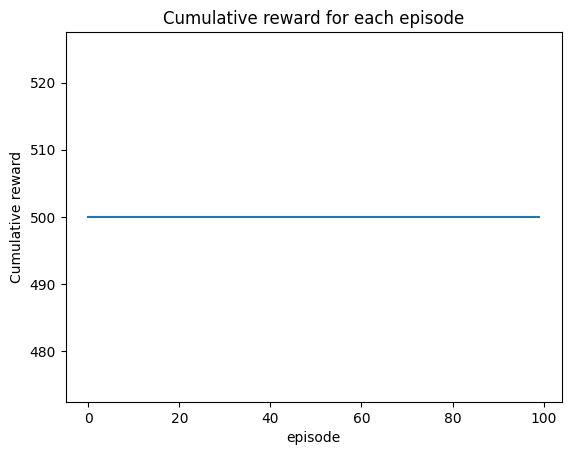

In [ ]:
plt.plot(score1)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()


### The agent gives an average score of 500, making it good enough.

In [ ]:
meanScoreTest = sum(score1)/len(score1)
print('Average Cumulative Score :', round(meanScoreTest))
print("Is my agent good enough :", meanScoreTest>=195)

Average Cumulative Score : 500
Is my agent good enough : True


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Task 3: Render one episode played by the RL agent.

In [ ]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

In [ ]:
env = RecordVideo(gym.make("CartPole-v0"), "./video")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n 
agentRender = DQNAgent(state_size, action_size)
agentRender.load("/content/answer_weigths.h5")
agentRender.epsilon = 0

observation = env.reset()
observation = np.reshape(observation, [1,state_size])

t= 0
while True:
    env.render()
    #your agent goes here
    action = agentRender.act(observation)
    observation, reward, done, info = env.step(action) 
    observation = np.reshape(observation, [1,state_size])

    # t+=1
    if done: 
      # print(t)
      break;    
env.close()
show_video()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 24)                120       
                                                                 
 dense_4 (Dense)             (None, 24)                600       
                                                                 
 dense_5 (Dense)             (None, 2)                 50        
                                                                 
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 [==============================] - 0s 24ms/step
